In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./crime.png
./model_data.csv
./Project_2.ipynb
./crime_rates.csv
./zipCodeToLatLong.csv
./.ipynb_checkpoints/Project_2-checkpoint.ipynb
./.ipynb_checkpoints/crime_rates-checkpoint.csv
./.ipynb_checkpoints/model_data-checkpoint.csv
./.ipynb_checkpoints/zipCodeToLatLong-checkpoint.csv
./housingData/data.csv
./housingData/raw_data.csv
./housingData/.ipynb_checkpoints/data-checkpoint.csv
./housingData/.ipynb_checkpoints/raw_data-checkpoint.csv
./scraper (no longer in use)/raw_data_sold.csv
./scraper (no longer in use)/package.log
./scraper (no longer in use)/HomeHarvest_20250910_003045.csv
./scraper (no longer in use)/.gitignore
./scraper (no longer in use)/data.csv
./scraper (no longer in use)/raw_data.csv
./scraper (no longer in use)/scraper.ipynb
./scraper (no longer in use)/.ipynb_checkpoints/data-checkpoint.csv
./scraper (no longer in use)/.ipynb_checkpoints/scraper-checkpoint.ipynb
./scraper (no longer in use)/.ipynb_checkpoints/HomeHarvest_20250910_003045-checkpoint.csv
./scraper (n

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Market prices are an important thing to consider when buying a house. This ML project aims to predict the price a house will be sold at given certain attributes. We must use data from public real estate websites and then build a property selling price predictor for a city, which is, in my case, Chicago. 

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I used the Python Library HomeHarvest, which scrapes data from Realtors.com, Zillow, and Redfin. I used it to scrap for any homes sold, pending, or for sale in Chicago. Then, I saved the data as a csv. 

In [2]:
# import libraries
from homeharvest import scrape_property
from datetime import datetime

## Scrape Data

This code is commented out for now since it takes a while for it to scrape and I need to be able to restart the kernel quickly.

In [3]:
# # use library to get sold property data

# current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filename = f"HomeHarvest_{current_timestamp}.csv"

# sold_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="sold",
#     past_days=730,
# )
# print(f"Number of sold properties: {len(sold_properties)}")
# print(sold_properties.head())

In [4]:
# # use library to get pending property data

# pending_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="pending",
#     past_days=730,
# )
# print(f"Number of pending properties: {len(pending_properties)}")
# print(pending_properties.head())

In [5]:
# # use library to get for sale property data

# for_sale_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="for_sale",
#     past_days=730,
# )
# print(f"Number of for sale properties: {len(for_sale_properties)}")
# print(for_sale_properties.head())

## Convert to Dataframe

In [6]:
import pandas as pd

In [7]:
# create dataframe based on all the properties gathered

# df = pd.concat([sold_properties, pending_properties, for_sale_properties])
# print(len(df))

In [8]:
# df.to_csv("raw_data.csv", index=False)

In [9]:
# load the housing data
df = pd.read_csv("./housingData/raw_data.csv")

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

## Drop duplicate properties and NaN values

In [10]:
# grab some initial columns and drop duplicates and NaNs

df = df[["property_id", "formatted_address", "zip_code", "style", "beds", 
                           "full_baths", "half_baths", "sqft", "year_built", 
                           "list_price", "sold_price", "latitude", "longitude", "stories", "days_on_mls", "neighborhoods"]]

df = df.dropna(subset=['zip_code', "list_price", "sold_price", "sqft", "beds", "full_baths"])
print(len(df))

df.drop_duplicates(inplace=True)
print(len(df))

10526
10432


In [11]:
df.to_csv("./housingData/data.csv", index=False)

I've taken the dataset and some of the columns I've estimated will have the greatest value in this predictor. After dropping the nan values within a few important columns, my dataset is down to 10,383. After dropping all the duplicate values, I'm down to 8779 properties. This is a signifcant decrease from my original count of 22,719. 

A few of the columns I got are less important and will NOT be used for training, just identification purposes, like formatting address and property id. Zip code and style will need to be one-hot-encoded since they are categorical variables, and I'll combined full and half baths into a single baths column. 

## Utility Functions

In [12]:
import matplotlib.pyplot as plt

In [13]:
# utility func for calc outliers (1.5 IQR rule)

def outlier_calc(data, val):
    q3 = data[f"{val}"].quantile(0.75)
    q1 = data[f"{val}"].quantile(0.25)
    iqr = q3 - q1
    print(f"outlier bounds: {q1 - 1.5 * iqr} to {q3 + 1.5 * iqr}")

    data = data[((q1 - 1.5 * iqr) <= data[f"{val}"]) & (data[f"{val}"] <= (q3 + 1.5 * iqr))]
    return data

In [14]:
# i'm predicting sold price

# checking for price outliers
print(df.info())
df_price = outlier_calc(df, "sold_price")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10432 entries, 0 to 23082
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        10432 non-null  int64  
 1   formatted_address  10432 non-null  object 
 2   zip_code           10432 non-null  int64  
 3   style              10432 non-null  object 
 4   beds               10432 non-null  float64
 5   full_baths         10432 non-null  float64
 6   half_baths         2880 non-null   float64
 7   sqft               10432 non-null  float64
 8   year_built         9680 non-null   float64
 9   list_price         10432 non-null  float64
 10  sold_price         10432 non-null  float64
 11  latitude           10390 non-null  float64
 12  longitude          10390 non-null  float64
 13  stories            6081 non-null   float64
 14  days_on_mls        10293 non-null  float64
 15  neighborhoods      10373 non-null  object 
dtypes: float64(11), int64(2), o

Calculating statistical outlier bounds gives us a sold price outlier of 0 - around 2 million. This is a very large range and is most likely due to Chicago's diverse housing market.

## Looking at Trends with Sold Price

In [15]:
# calculate age using the current year

df["age"] = datetime.now().year - df["year_built"]
df.drop(columns="year_built", inplace=True)

In [16]:
# convert to numbers

cols = df.columns.difference(['formatted_address', 'style', 'neighborhoods'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

### Zip Code

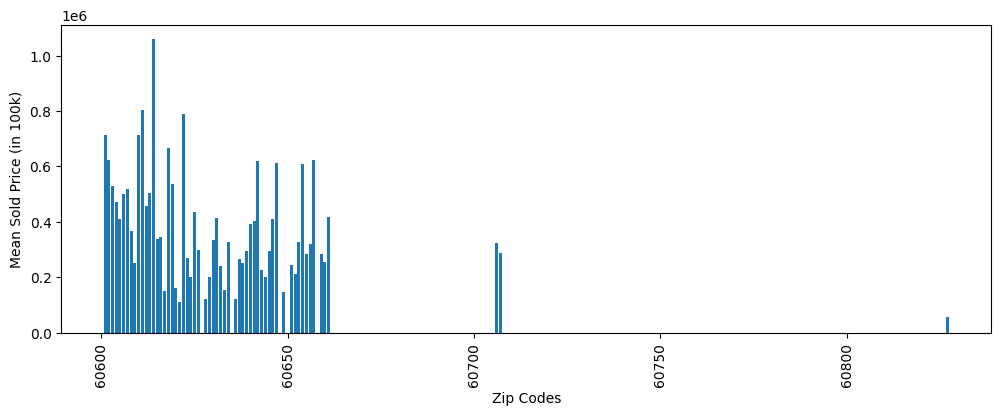

In [17]:
# zip_code vs. price
# would indicate richer zip codes

plt.figure(figsize=(12, 4))

grouped_data = df.groupby("zip_code", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["zip_code"], grouped_data["sold_price"])

plt.xticks(rotation=90)
plt.xlabel("Zip Codes")
plt.ylabel("Mean Sold Price (in 100k)")
plt.show()

The zipcodes need to be encoded.
The highest mean selling price has a zipcode of 60614, and the lowest is 60827. 

### Location

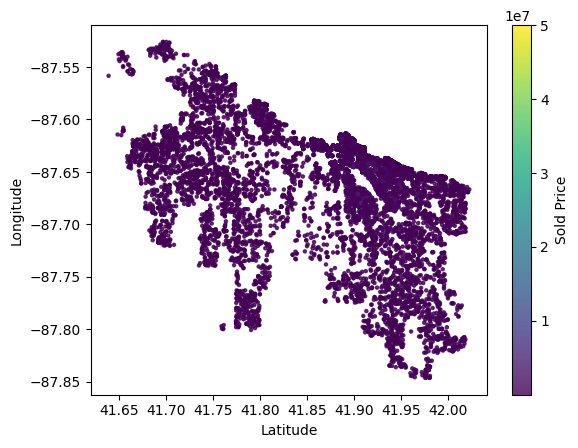

In [18]:
# graph the location of the houses gathered and their prices

plt.scatter(df["latitude"], df["longitude"], c=df["sold_price"], cmap='viridis', s=5, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

This map traces out the shape of Chicago with all of the properties mapped using price as color. It's clear the majority of properties are just less or around 10^7 dollars. This may be a better alternative than using the zipcodes, although the numbers may vary a lot compared to using the zipcodes to "bin" the coordinates.

### Coords of Zipcode

In [19]:
# find the latitude and longitude for the zipcode centroids

lat_long_df = pd.read_csv("zipCodeToLatLong.csv")

df.rename(columns={"latitude": "zip_lat", "longitude": "zip_long"}, inplace=True)
df['zip_code'] = df['zip_code'].astype(int)
df = df.merge(lat_long_df, left_on="zip_code", right_on="zip", how="left")

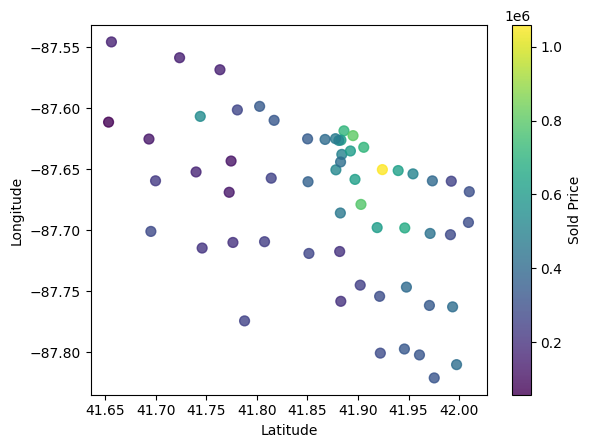

In [20]:
# plot the mean sold price for the zipcodes gathered

grouped_data = df.groupby("zip_code", as_index=False)[["sold_price", "zip_lat", "zip_long"]].mean()

plt.scatter(grouped_data["zip_lat"], grouped_data["zip_long"], c=grouped_data["sold_price"], cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Grouping the data by zipcode gives us a clearer picture of where the richer areas of Chicago are (downtown). I still might use the raw latitudes and longitudes because they're more precise than this binning. 

### Style of House

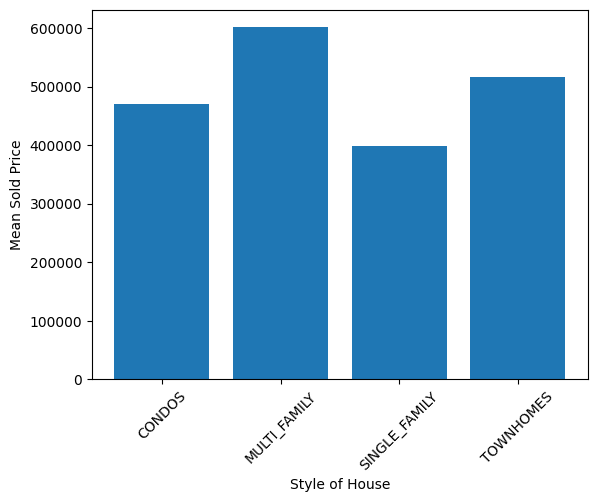

In [21]:
# style vs. price
# larger homes, pricier

grouped_data = df.groupby("style", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["style"], grouped_data["sold_price"])

plt.xticks(rotation=45)
plt.xlabel("Style of House")
plt.ylabel("Mean Sold Price")
plt.show()

The trends seem to make sense, with houses being higher than condos or single family houses. However, this metric might just be easier to figure out using the number of beds and baths. For now, if I choose to use this, label encoding should work just fine since these can somewhat be predicted by their size. 

### Beds

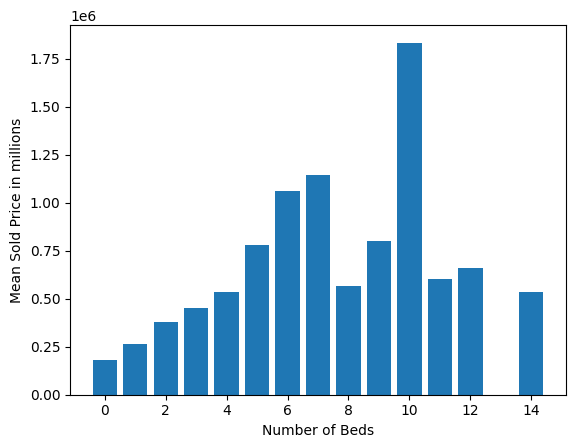

In [22]:
# beds vs. price
# more beds, higher price

grouped_data = df.groupby("beds", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["beds"], grouped_data["sold_price"])

plt.xlabel("Number of Beds")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: 0.5 to 4.5


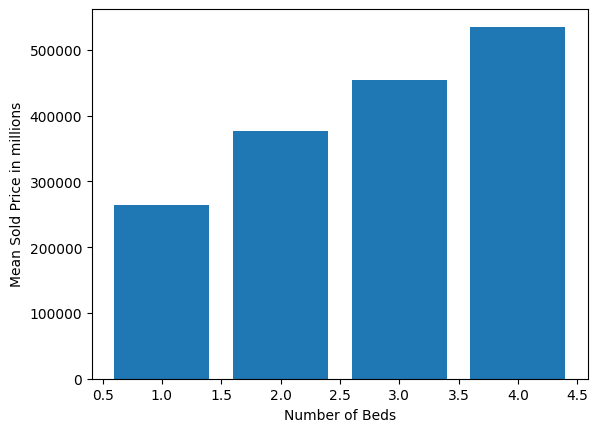

In [23]:
# take out the outlier beds and re-plot

df_beds = outlier_calc(df, "beds")

grouped_data = df_beds.groupby("beds", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["beds"], grouped_data["sold_price"])

plt.xlabel("Number of Beds")
plt.ylabel("Mean Sold Price in millions")
plt.show()

The sold price does increase and act as intended until about 7 rooms, and then it starts to go a little weird. 10 rooms has the maximum mean sold price, but 8, 11, and 14, which are all supposed to be high according to the trend, are very low, about the same price as the 5 room properties.

### Baths

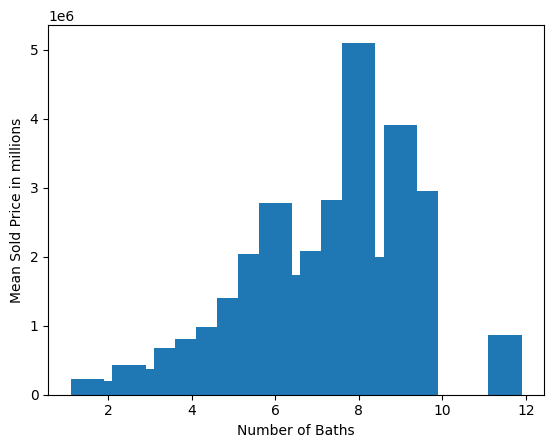

In [24]:
# baths vs. price
# more baths, higher price

df["baths"] = df["full_baths"] + 0.5 * df["half_baths"].bfill()

grouped_data = df.groupby("baths", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["baths"], grouped_data["sold_price"])

plt.xlabel("Number of Baths")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: 0.0 to 4.0


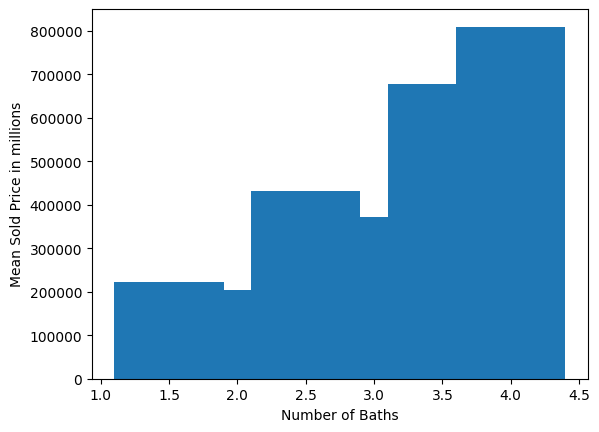

In [25]:
# take out the outlier baths and re-plot

df_baths = outlier_calc(df, "baths")

grouped_data = df_baths.groupby("baths", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["baths"], grouped_data["sold_price"])

plt.xlabel("Number of Baths")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute does mostly follow the trend of increases rooms with increasing prices. It has a peak at around 8 baths. 

### Number of Rooms (Bed + Bath)

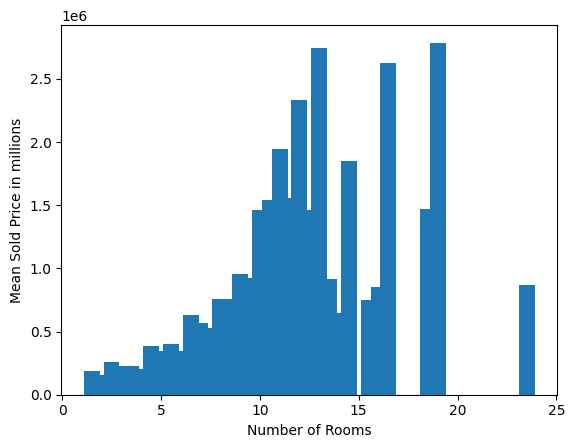

In [26]:
# combined bath + beds vs. sold price
# more rooms, higher price

df["num_of_rooms"] = (df["baths"] + df["beds"]).bfill()

df["num_of_rooms"] = df["num_of_rooms"].replace(0, 1)

grouped_data = df.groupby("num_of_rooms", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["num_of_rooms"], grouped_data["sold_price"])

plt.xlabel("Number of Rooms")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: 1.5 to 9.5


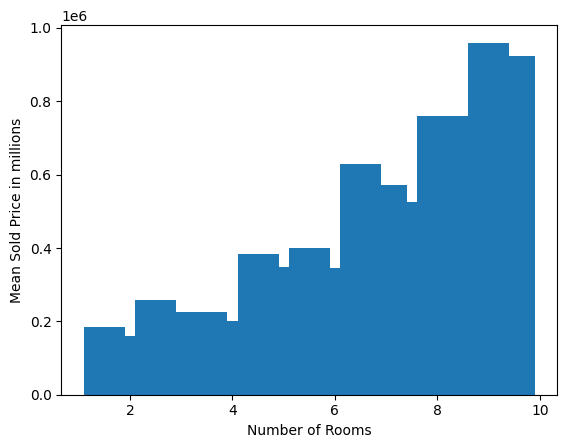

In [27]:
# take out the outlier numbers of rooms and re-plot

df_num_of_rooms = outlier_calc(df, "num_of_rooms")

grouped_data = df_num_of_rooms.groupby("num_of_rooms", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["num_of_rooms"], grouped_data["sold_price"])

plt.xlabel("Number of Rooms")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This seems to follow the trend, but there are some odd lower values at some points, like at 16 and 24 rooms. Not sure why the trend doesn't apply at this higher room counts.

### Square Feet

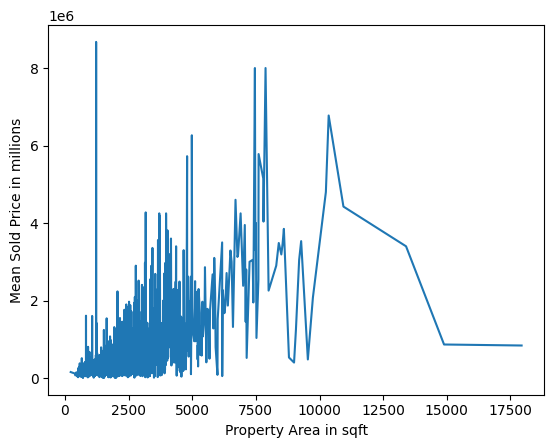

In [28]:
# sqft vs. sold price
# bigger house, higher price

grouped_data = df.groupby("sqft", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["sqft"], grouped_data["sold_price"])

plt.xlabel("Property Area in sqft")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: -375.0 to 3425.0


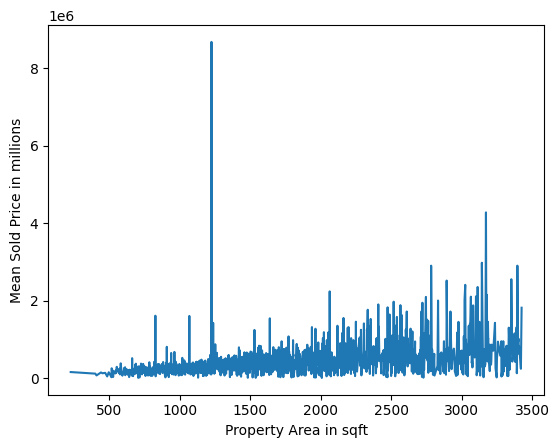

In [29]:
# take out the outlier sqft areas and re-plot

df_sqft = outlier_calc(df, "sqft")

grouped_data = df_sqft.groupby("sqft", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["sqft"], grouped_data["sold_price"])

plt.xlabel("Property Area in sqft")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute follows the trend as predicted. There are outliers for the properties with 15000 sqft which goes down, so it's a similar phenomenon as the bath and bed room issue of going down at extremely high values.

### Age

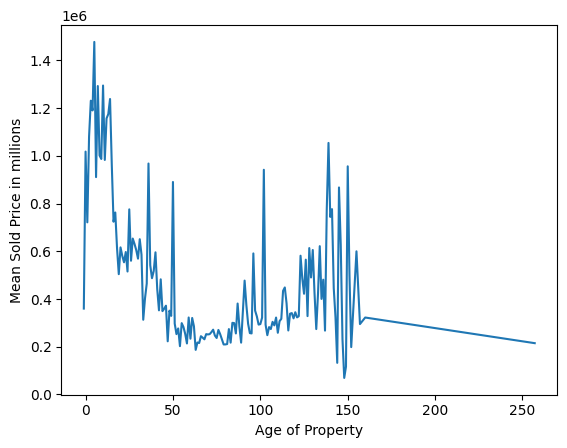

In [30]:
# age vs. sold price
# newer houses, higher price

grouped_data = df.groupby("age", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["age"], grouped_data["sold_price"])

plt.xlabel("Age of Property")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute has a lot of variation in the trend. The price is higher if the property is new, as expected, but it also seems to peak around 150 years in age, which might be able to be attributed to larger properties being older like historical buildings. 

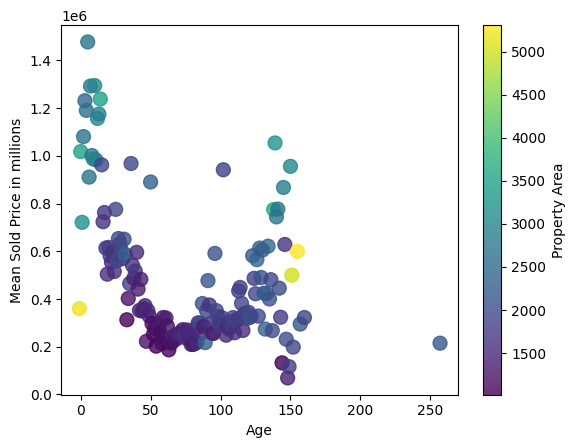

In [31]:
# plot age vs. price

grouped_data = df.groupby("age", as_index=False)[["sold_price", "sqft"]].mean()

plt.scatter(grouped_data["age"], grouped_data["sold_price"], c=grouped_data["sqft"], cmap='viridis', s=100, alpha=0.8)
plt.colorbar(label='Property Area')

plt.xlabel("Age")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This second graph actually doesn't follow the trend I expected it would. The correlation between property age and the price is quadratic, with peaks in the younger properties and extremely old properties.

outlier bounds: -89.0 to 215.0


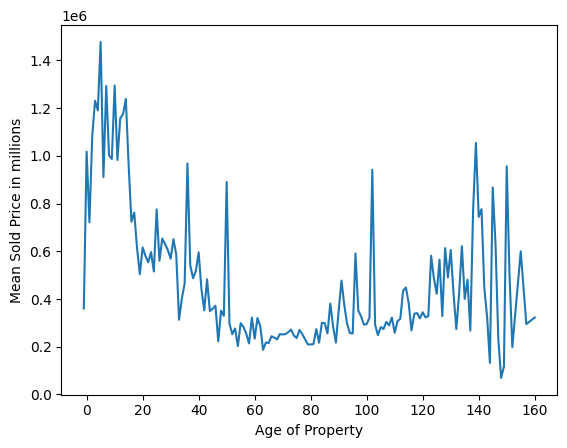

In [32]:
# take out the outlier ages and re-plot

df_age = outlier_calc(df, "age")

grouped_data = df_age.groupby("age", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["age"], grouped_data["sold_price"])

plt.xlabel("Age of Property")
plt.ylabel("Mean Sold Price in millions")
plt.show()

### Distance to Downtown

In [33]:
# chicago's downtown is very busy and the center of everything
# so houses closer to downtown will be more in demand so high prices

df.columns = df.columns.str.strip()

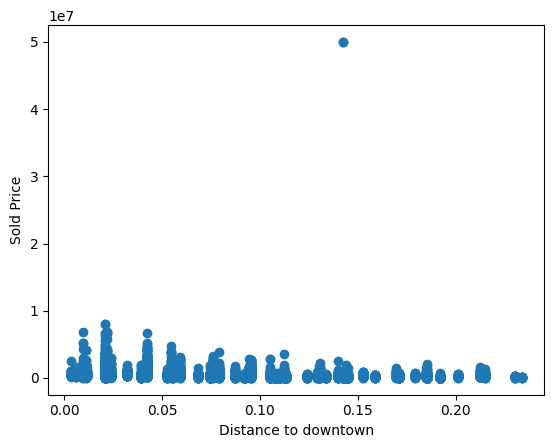

In [34]:
df["dist_to_downtown"] = ((df["latitude"] - 41.8832)**2 + (df["longitude"] + 87.6324)**2) ** 0.5

plt.scatter(df["dist_to_downtown"], df["sold_price"])

plt.xlabel("Distance to downtown")
plt.ylabel("Sold Price")
plt.show()

### Crime Rate

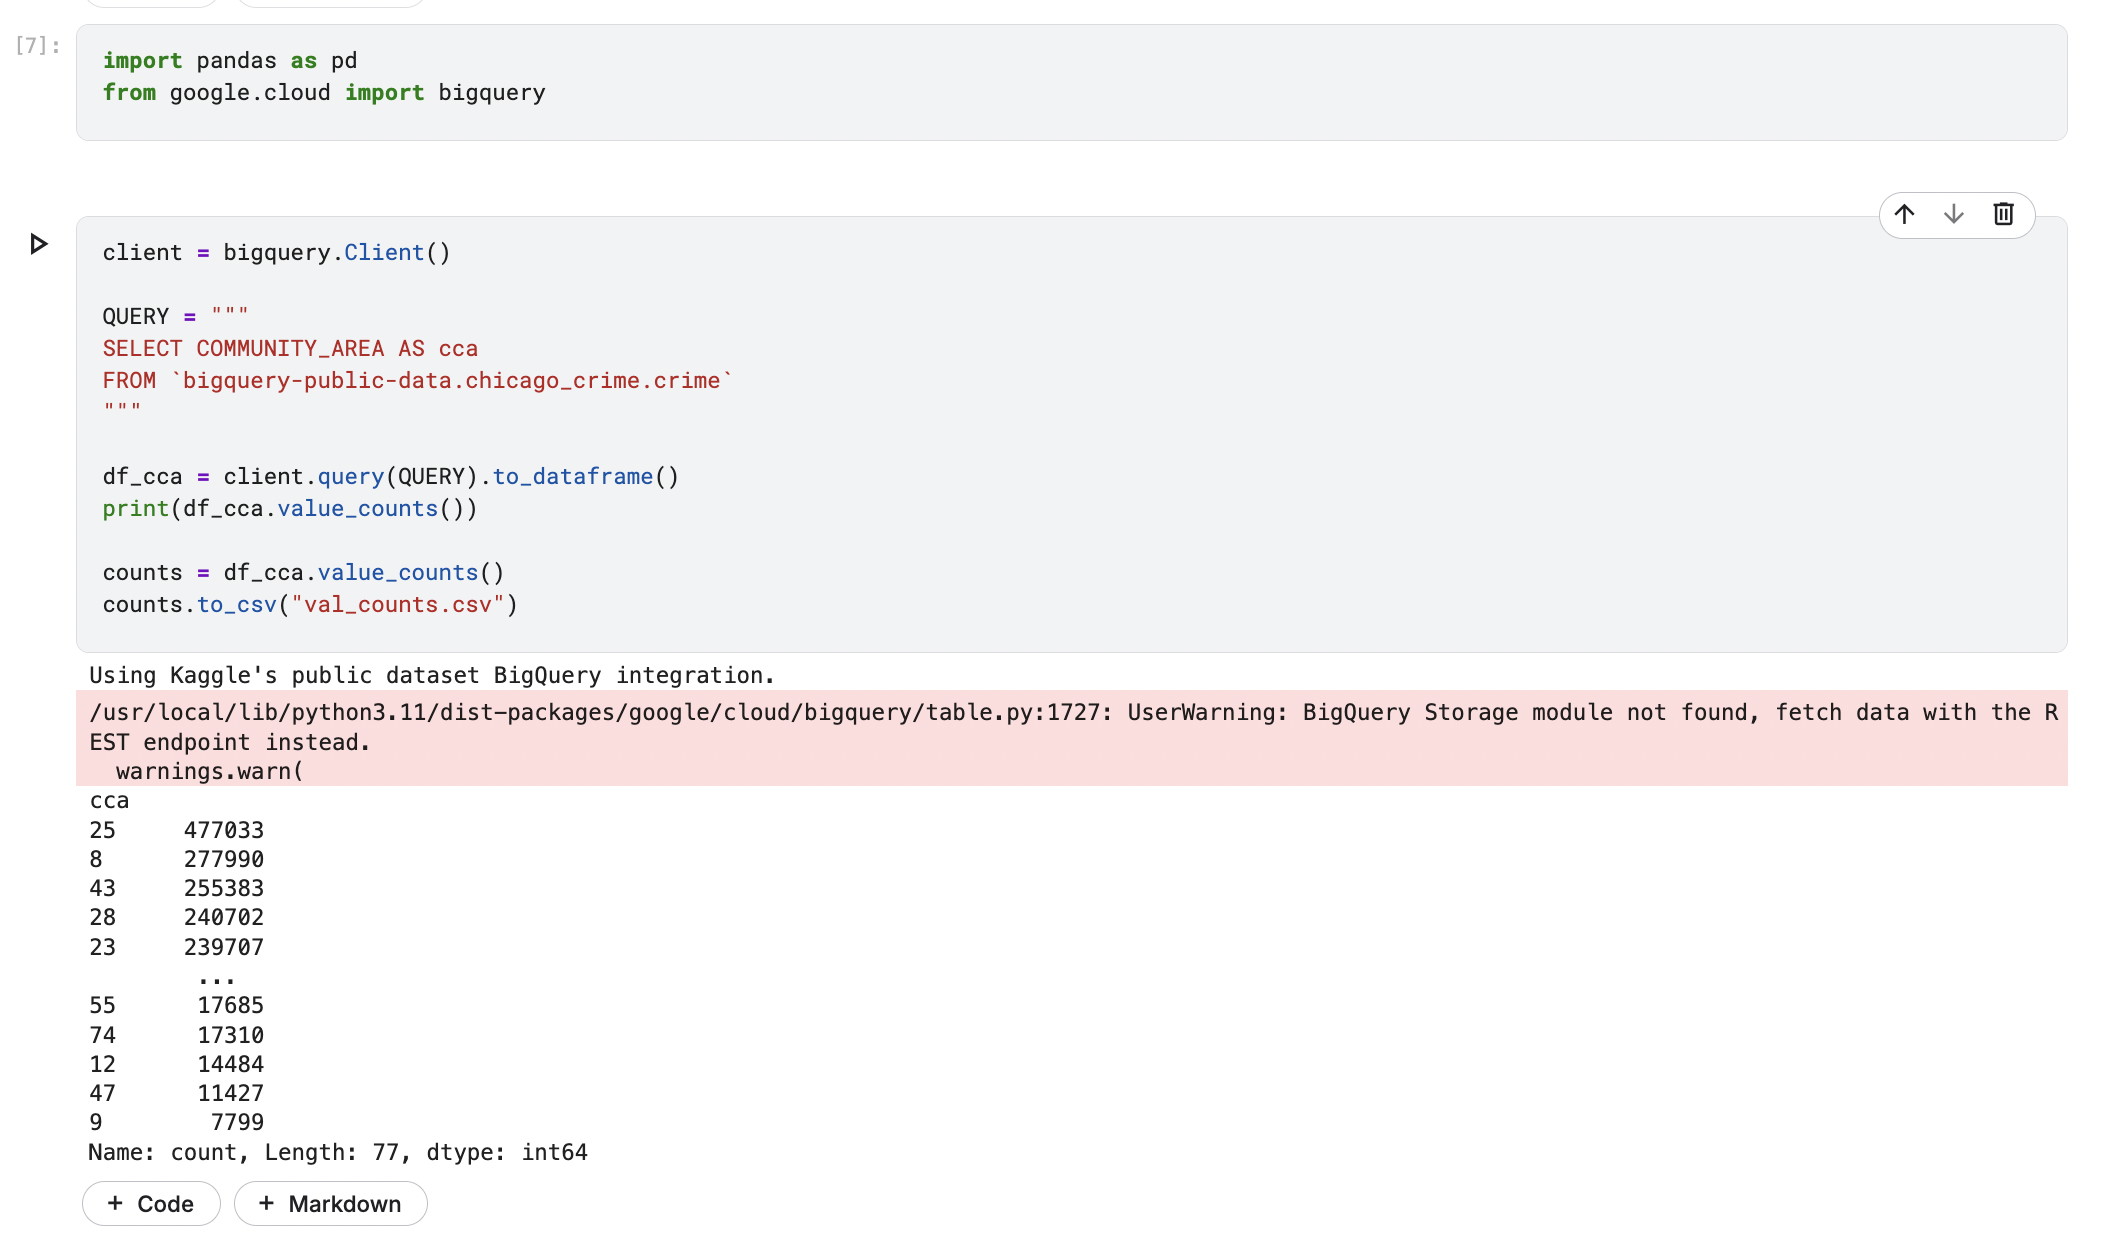

In [35]:
# houses in areas with more crime are probably going to be less valued because no one wants to live in an area with lots of crime

from IPython.display import Image
Image(filename='crime.png')

I had to grab data from Chicago's public crime dataset, which has every crime committed in Chicago since 2001. It was extremely large (7 million rows) so I had to use Kaggle, so I've uploaded a screenshot of my code there too. 

In [36]:
# read the various csvs of data i've gathered for chicago's demographics

neighborhood_to_cca = pd.read_csv("./chicagoData/chicago_cca_exploded.csv")

crime_counts = pd.read_csv("./chicagoData/val_counts.csv")

# calculuate crime rate per resident
# https://www.kaggle.com/datasets/sergejnuss/chicago-community-areas-demographics
population = pd.read_csv("./chicagoData/chicago_population.CSV", delimiter=";", header=None)
population = population.T

population.columns = population.iloc[0]
population = population[1:]
population = population.reset_index(drop=True)

population["population"] = population["population"].astype(float)
population["Community Area"] = population["Community Area"].astype(int)

population.to_csv("chicagoData/chicago_demographics.csv")
population.head()

,Community Area,name,population,income,latinos,blacks,white,asian,other
0,1,Rogers Park,54991.0,39482,0.244,0.263,0.393,0.064,0.036
1,2,West Ridge,71942.0,47323,0.204,0.111,0.427,0.225,0.032
2,3,Uptown,56362.0,40324,0.142,0.2,0.516,0.114,0.028
3,4,Lincoln Square,39493.0,57749,0.191,0.038,0.631,0.111,0.029
4,5,North Center,31867.0,81524,0.136,0.023,0.773,0.045,0.022


In [37]:
# merge datasets to get a dataframe with crime counts and populations so i can calculate crime rate

crime_counts = crime_counts.merge(
    population,
    left_on="cca",
    right_on="Community Area",
    how="left"
)

crime_counts.head()

,cca,count,Community Area,name,population,income,latinos,blacks,white,asian,other
0,25,477033,25,Austin,98514.0,32358,0.089,0.851,0.044,0.006,0.01
1,8,277990,8,Near North Side,80484.0,76290,0.049,0.108,0.721,0.101,0.02
2,43,255383,43,South Shore,52010.0,27903,0.017,0.949,0.014,0.002,0.018
3,28,240702,28,Near West Side,54881.0,62770,0.092,0.315,0.42,0.146,0.027
4,23,239707,23,Humboldt Park,56323.0,29605,0.533,0.409,0.044,0.004,0.009


In [38]:
crime_counts = crime_counts[["cca", "count", "population"]]

# https://oag.ca.gov/sites/all/files/agweb/pdfs/cjsc/stats/computational_formulas.pdf
crime_counts["crime_rate"] = ((crime_counts["count"] / 24) / crime_counts["population"]) * 100000

crime_counts.head()

,cca,count,population,crime_rate
0,25,477033,98514.0,20176.193231
1,8,277990,80484.0,14391.576794
2,43,255383,52010.0,20459.446901
3,28,240702,54881.0,18274.539458
4,23,239707,56323.0,17733.060502


In [39]:
# pull the correct crime rate based on the cca which is based on the neighborhood

neighborhood_to_cca.rename(columns={"Community Area Number": "cca", "Neighborhoods": "cca_nb"}, inplace=True)

# merge datasets to have neighborhoods and crime rates
neighborhood_to_cca = neighborhood_to_cca.merge(
    crime_counts,
    left_on="cca",
    right_on="cca",
    how="left"
)

neighborhood_to_cca.to_csv("crime_rates.csv")

In [40]:
# look for neighborhoods that are in the csv i have and match the community area number
# then merge with the big dataset to add the crime columns

valid_names = set(neighborhood_to_cca["cca_nb"])

def pick_first_match(neighborhood_str):
    for n in map(str.strip, str(neighborhood_str).split(",")):
        if n in valid_names:
            return n
    return None

df["neighborhood_clean"] = df["neighborhoods"].apply(pick_first_match)

df = df.merge(
    neighborhood_to_cca,
    left_on="neighborhood_clean",
    right_on="cca_nb",
    how="left"
)

df.drop(columns=["cca_nb", "cca_name", "neighborhood_clean"], inplace=True)

In [41]:
df.dropna(subset=["cca"], inplace=True)

df.head()

,property_id,formatted_address,zip_code,style,beds,full_baths,half_baths,sqft,list_price,sold_price,...,zip,latitude,longitude,baths,num_of_rooms,dist_to_downtown,cca,count,population,crime_rate
0,8818482037,"100 E Bellevue Pl Apt 5F, Chicago, IL, 60611",60611,CONDOS,2.0,2.0,NaN,1400.0,600000.0,585000.0,...,60611,41.894742,-87.615073,2.5,4.5,0.020819,9.0,7799.0,11187.0,2904.785316
1,8216192504,"4124 N Pontiac Ave, Chicago, IL, 60634",60634,SINGLE_FAMILY,3.0,2.0,NaN,1766.0,365000.0,345000.0,...,60634,41.946189,-87.806117,2.5,5.5,0.184784,67.0,215489.0,35505.0,25288.574379
2,9705735225,"211 N Harbor Dr Apt 1304, Chicago, IL, 60601",60601,CONDOS,2.0,2.0,NaN,1251.0,990000.0,995000.0,...,60601,41.885155,-87.621512,2.5,4.5,0.011062,9.0,7799.0,11187.0,2904.785316
3,8018556780,"11656 S Avenue N, Chicago, IL, 60617",60617,SINGLE_FAMILY,4.0,2.0,NaN,1788.0,429000.0,420000.0,...,60617,41.714417,-87.555761,2.5,6.5,0.185368,32.0,197764.0,29283.0,28139.762547
4,8509659172,"155 N Harbor Dr Apt 1111, Chicago, IL, 60601",60601,CONDOS,2.0,2.0,NaN,1369.0,480000.0,460000.0,...,60601,41.885155,-87.621512,2.5,4.5,0.011062,9.0,7799.0,11187.0,2904.785316


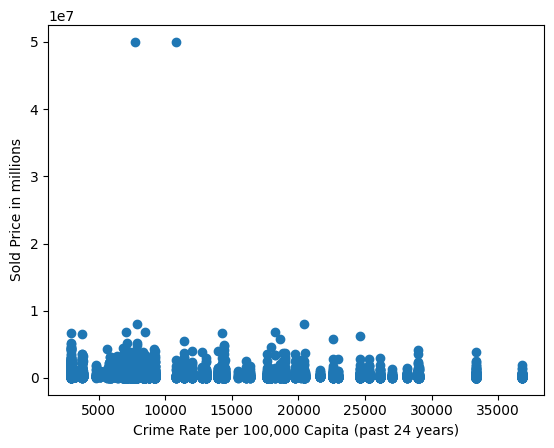

In [42]:
# plot crime rate per 100,000 people v. sold price of houses

plt.scatter(df["crime_rate"].sort_values(), df["sold_price"])

plt.xlabel("Crime Rate per 100,000 Capita (past 24 years)")
plt.ylabel("Sold Price in millions")
plt.show()

From this visualization, I see a very slight trend downwards. As crime increases, the mean sold price slightly decreases as well.

In [43]:
# look for places within certain neighborhoods with good public schools
# https://www.seechicagorealestate.com/blog/chicago-neighborhoods-with-the-best-public-schools/
# https://www.fultongrace.com/blog/chicago-neighborhoods-with-the-best-public-high-schools/

neighborhoods_good_schools = ["Lakeview", "Lincoln Park", "Old Town", "North Park", "Roscoe Village", "Near North Side", "Printers Row", "Ravenswood", "Logan Square"]

df["neighborhoods"] = df["neighborhoods"].fillna("")
df["good_school_nearby"] = df["neighborhoods"].apply(
    lambda x: 1 if any(n in x.split(", ") for n in neighborhoods_good_schools) else 0
)

In [44]:
school_corr = df['good_school_nearby'].corr(df['sold_price'])
print(f"Correlation between good school district and sold price of house: {100 * school_corr}")

Correlation between good school district and sold price of house: 21.041427224818857


This is a positive correlation, although not as large as I would've thought. This is probably because there's a decent amount of people in Chicago who are not looking for schools and are just living in Chicago for work.

## Conclusions

From all of these visualizations, I've seen that I need to do some feature engineering and manipulation to get some good trends, since Chicago has a very diverse market that might cause issues for me.

# 4.Prepare the Data


Apply any data transformations and explain what and why


After looking through the statistics, I've determined the features I'll be including to maximize prediction accuracy and minimize parameter count are number of rooms, property area, age, and geographic location. Although number of rooms and property area seem to follow very similar trends, so I might be able to not use that attribute.

In [45]:
# encode the houses in order of size to see if there's a correlation

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['SINGLE_FAMILY', 'CONDOS', 'TOWNHOMES', 'MULTI_FAMILY']])
df['home_style'] = encoder.fit_transform(df[['style']])

In [46]:
# fill any stories values that are 0 with 1 (we don't have 0 floor houses)
df["stories"] = df["stories"].replace(0, 1)

In [47]:
df.head()

,property_id,formatted_address,zip_code,style,beds,full_baths,half_baths,sqft,list_price,sold_price,...,longitude,baths,num_of_rooms,dist_to_downtown,cca,count,population,crime_rate,good_school_nearby,home_style
0,8818482037,"100 E Bellevue Pl Apt 5F, Chicago, IL, 60611",60611,CONDOS,2.0,2.0,NaN,1400.0,600000.0,585000.0,...,-87.615073,2.5,4.5,0.020819,9.0,7799.0,11187.0,2904.785316,1,1.0
1,8216192504,"4124 N Pontiac Ave, Chicago, IL, 60634",60634,SINGLE_FAMILY,3.0,2.0,NaN,1766.0,365000.0,345000.0,...,-87.806117,2.5,5.5,0.184784,67.0,215489.0,35505.0,25288.574379,0,0.0
2,9705735225,"211 N Harbor Dr Apt 1304, Chicago, IL, 60601",60601,CONDOS,2.0,2.0,NaN,1251.0,990000.0,995000.0,...,-87.621512,2.5,4.5,0.011062,9.0,7799.0,11187.0,2904.785316,0,1.0
3,8018556780,"11656 S Avenue N, Chicago, IL, 60617",60617,SINGLE_FAMILY,4.0,2.0,NaN,1788.0,429000.0,420000.0,...,-87.555761,2.5,6.5,0.185368,32.0,197764.0,29283.0,28139.762547,0,0.0
4,8509659172,"155 N Harbor Dr Apt 1111, Chicago, IL, 60601",60601,CONDOS,2.0,2.0,NaN,1369.0,480000.0,460000.0,...,-87.621512,2.5,4.5,0.011062,9.0,7799.0,11187.0,2904.785316,0,1.0


In [48]:
# look at the correlation between sold price and every other feature
correlation_matrix = df.drop(columns=["formatted_address", "property_id", "zip_code", "style", "list_price", "zip", "neighborhoods"]).corr()
correlation_matrix = correlation_matrix["sold_price"].sort_values(ascending=False)
print(correlation_matrix)

sold_price            1.000000
sqft                  0.365999
baths                 0.293327
full_baths            0.291698
half_baths            0.281390
num_of_rooms          0.231122
good_school_nearby    0.210414
beds                  0.149023
latitude              0.148651
zip_lat               0.146835
home_style            0.061427
stories               0.060137
days_on_mls           0.060054
zip_long              0.043714
longitude             0.041917
population            0.039199
count                -0.005436
cca                  -0.112505
crime_rate           -0.128287
age                  -0.146191
dist_to_downtown     -0.209575
Name: sold_price, dtype: float64


From this correlation matrix, I can see which features are most closely correlated and then pick a few to start with.

In [49]:
# create the model dataframe from the desired features and drop all the outliers
model_df = df[["sold_price", "sqft", "num_of_rooms", "age", "dist_to_downtown", "good_school_nearby", "crime_rate"]]

for x in model_df.drop(columns=["good_school_nearby"]).columns:
    model_df = outlier_calc(model_df, x)

print(model_df.info())

outlier bounds: -345000.0 to 975000.0
outlier bounds: -190.0 to 3074.0
outlier bounds: 0.5 to 8.5
outlier bounds: -64.0 to 200.0
outlier bounds: -0.13239347485815428 to 0.33321364714701596
outlier bounds: -11994.792105397599 to 30223.398133208575
<class 'pandas.core.frame.DataFrame'>
Index: 8084 entries, 0 to 11127
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sold_price          8084 non-null   float64
 1   sqft                8084 non-null   float64
 2   num_of_rooms        8084 non-null   float64
 3   age                 8084 non-null   float64
 4   dist_to_downtown    8084 non-null   float64
 5   good_school_nearby  8084 non-null   int64  
 6   crime_rate          8084 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 505.2 KB
None


In [50]:
model_df.to_csv("model_data.csv", index=False)

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


There are 5 models I want to try:
1. Random Forest Regressor
2. Linear Multivariate Regressor
3. Support Vector Regression
4. KNN Regressor
5. Gradient Boosting Regressor

I will use various accuracy measures to determine which model to use for the final product.

In [51]:
model_df.head()

,sold_price,sqft,num_of_rooms,age,dist_to_downtown,good_school_nearby,crime_rate
0,585000.0,1400.0,4.5,54.0,0.020819,1,2904.785316
1,345000.0,1766.0,5.5,77.0,0.184784,0,25288.574379
3,420000.0,1788.0,6.5,28.0,0.185368,0,28139.762547
4,460000.0,1369.0,4.5,51.0,0.011062,0,2904.785316
5,175000.0,2000.0,6.5,105.0,0.144992,0,7719.079035


## Utility Functions

In [52]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [53]:
features = ["sqft", "num_of_rooms", "age", "dist_to_downtown", "good_school_nearby", "crime_rate"]

X = model_df[features]
y = model_df['sold_price']

In [54]:
# import scaler
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

In [55]:
# splt into train test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_scaler.fit(X_train)
# scale x
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_scaled = X_scaler.transform(X)

In [56]:
# create a utility func to return the stats for every model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score

def return_stats(model):
    global X_train_scaled, X_test_scaled, y_train, y_test
    
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    print("Train scores")
    print(f"RMSE: {train_rmse}")
    print(f"MAE: {train_mae}")
    print(f"MA%E: {train_mape}")
    print(f"R^2: {train_r2}\n")
    
    y_test_pred = model.predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("Test scores")
    print(f"RMSE: {test_rmse}")
    print(f"MAE: {test_mae}")
    print(f"MA%E: {test_mape}")
    print(f"R^2: {test_r2}\n")


    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2']

    scores = cross_validate(model, X_train_scaled, y_train, scoring=scoring)
    print("Train scores with cross validation")
    print(f"Mean RMSE: {-1 * scores['test_neg_root_mean_squared_error'].mean()}")
    print(f"Mean MAE: {-1 * scores['test_neg_mean_absolute_error'].mean()}")
    print(f"Mean MA%E: {-1 * scores['test_neg_mean_absolute_percentage_error'].mean()}")
    print(f"Mean R^2: {scores['test_r2'].mean()}\n")

## Training Models

In [57]:
# random forest model
rf = RandomForestRegressor(random_state=42)
return_stats(rf)

Train scores
RMSE: 42380.26558568581
MAE: 28544.672676040354
MA%E: 6.887099981698782
R^2: 0.9580722370765139

Test scores
RMSE: 109052.13443496953
MAE: 73152.50046864625
MA%E: 51.04518748612783
R^2: 0.7180658538982447

Train scores with cross validation
Mean RMSE: 109470.59477233724
Mean MAE: 76368.04307663554
Mean MA%E: 10.576135389563925
Mean R^2: 0.7196316650436009



This model is performing way better on the train data that test data, indicating overfitting. However, the test and cross validation r^2 values are pretty good!

In [58]:
# svr model
svr = SVR()
return_stats(svr)

Train scores
RMSE: 211155.3101279685
MAE: 161125.45306133758
MA%E: 5.455415407023273
R^2: -0.04082654081268822

Test scores
RMSE: 211224.22642736498
MAE: 159590.9226147448
MA%E: 17.95844648269604
R^2: -0.05771044738228914

Train scores with cross validation
Mean RMSE: 211137.2410701663
Mean MAE: 161177.4244398545
Mean MA%E: 5.4405447392755715
Mean R^2: -0.04101635321655572



This model is doing very poorly. It's about 160k off on every prediction, and the R^2 values indicate that this model is worse than just guessing the price.

In [59]:
# knn model
knn = KNeighborsRegressor()
return_stats(knn)

Train scores
RMSE: 107783.1389566276
MAE: 78103.51025204886
MA%E: 8.233986042936182
R^2: 0.7288085471382153

Test scores
RMSE: 133624.40592925242
MAE: 95231.09461966605
MA%E: 48.26159948518227
R^2: 0.576697423010148

Train scores with cross validation
Mean RMSE: 135978.67829371188
Mean MAE: 99455.92175000088
Mean MA%E: 12.05723382422521
Mean R^2: 0.5678475244345715



This model has the best r^2 value for train besides random forest, but it is overfitting A LOT. It also is off by around 100k, which is not great.

In [60]:
# gradient boosting model
gbr = GradientBoostingRegressor()
return_stats(gbr)

Train scores
RMSE: 114416.40637245598
MAE: 85738.58896645324
MA%E: 10.964244106804045
R^2: 0.6944016891506868

Test scores
RMSE: 122687.38008094556
MAE: 89945.28244891873
MA%E: 48.92217060493991
R^2: 0.6431554054904451

Train scores with cross validation
Mean RMSE: 120058.95100427761
Mean MAE: 89851.4708367452
Mean MA%E: 11.127684528359294
Mean R^2: 0.6629678899140762



This model has the best performance besides the random forest regressor. It's not overfitting that much at all. It is still around 90k off of every prediction though.

In [61]:
# save base model

import joblib

joblib.dump(rf, './models/base_rf_model.pkl')

['./models/base_rf_model.pkl']

There is another type of graident boosting model I can use called xgboost. It doesn't use scikit learn but it is apparently very good!

In [62]:
# !pip install xgboost

In [63]:
# https://machinelearningmastery.com/xgboost-for-regression/
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold

num_round = 100

xg = xgb.XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = abs(scores)

scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2']

scores = cross_validate(xg, X_train, y_train, scoring=scoring)
print("Train scores with cross validation")
print(f"Mean RMSE: {-1 * scores['test_neg_root_mean_squared_error'].mean()}")
print(f"Mean MAE: {-1 * scores['test_neg_mean_absolute_error'].mean()}")
print(f"Mean MA%E: {-1 * scores['test_neg_mean_absolute_percentage_error'].mean()}")
print(f"Mean R^2: {scores['test_r2'].mean()}\n")

Train scores with cross validation
Mean RMSE: 111800.49819586526
Mean MAE: 79302.26145817067
Mean MA%E: 10.35049623033723
Mean R^2: 0.7077230417452594



In [64]:
joblib.dump(xg, './models/base_xgb_model.pkl')

['./models/base_xgb_model.pkl']

This model is doing very well, better than the graident boosting but not better than the random forest.

## Conclusion
From these tests, I have determined that the random forest and xgboost are the best models.

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [65]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

In [66]:
# load the previous model (not really necessary)

rf_model = joblib.load('./models/base_rf_model.pkl')
xgb_model = joblib.load('./models/base_xgb_model.pkl')

## Random Forest Tuning

In [67]:
# def parameters to change and random search through them for best random forest model
rf_param_dist = {'n_estimators': [100, 300, 500],
              'max_depth': [None] + list(range(5, 51, 5)), 
              'min_samples_split': randint(2, 20),
              'min_samples_leaf': randint(1, 10),
             }

rand_rf = RandomizedSearchCV(rf_model, 
                             param_distributions=rf_param_dist,
                             cv=5,
                             n_iter=100,
                             random_state=42, 
                             n_jobs=-1,
                             scoring='r2')

rand_rf.fit(X_train, y_train)
print("Best Params for random for random forest:", rand_rf.best_params_)
print("Best CV Score for random for random forest:", rand_rf.best_score_)
best_rf = rand_rf.best_estimator_
print("Feature Importances:", best_rf.feature_importances_)

Best Params for random for random forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}
Best CV Score for random for random forest: 0.7171213998319288
Feature Importances: [0.31462444 0.03413402 0.34231955 0.19925993 0.03169553 0.07796653]


In [68]:
joblib.dump(best_rf, './models/tuned_rf_model.pkl')

['./models/tuned_rf_model.pkl']

This made my r^2 value 0.7171, which is 0.02 less than my base model's cross validation r^2 value.

## XGBoost Tuning

In [69]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h-step-1-fix-learning-rate-and-number-of-estimators-for-tuning-tree-based-parameters
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

# random search through some parameters for the xgboost model
xgb_param_dist = {'max_depth': [None] + list(range(1, 10)),
                  'min_child_weight': range(1, 12),
                  'gamma': [i/10.0 for i in range(0,5)],
                  'subsample': [i/10.0 for i in range(1,10)],
                  'colsample_bytree':[i/10.0 for i in range(6,10)],
                  'learning_rate': [0.01, 0.05, 0.1, 0.2],
                  'n_estimators': [100, 200, 500, 1000],
                  'reg_lambda': [0.5, 1, 1.5, 2, 5]
                 }

rand_xgb = RandomizedSearchCV(xgb_model, 
                             param_distributions=xgb_param_dist,
                             cv=5,
                             n_iter=100,
                             random_state=42, 
                             n_jobs=-1,
                             scoring='r2')

rand_xgb.fit(X_train, y_train)
print("Best Params for random for XGB :", rand_xgb.best_params_)
print("Best CV Score for random for XGB:", rand_xgb.best_score_)
best_xgb = rand_xgb.best_estimator_
print("Feature Importances:", best_xgb.feature_importances_)

Best Params for random for XGB : {'subsample': 0.7, 'reg_lambda': 5, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best CV Score for random for XGB: 0.7262540422443206
Feature Importances: [0.16252111 0.05474713 0.16386452 0.20352072 0.30525294 0.11009351]


In [70]:
joblib.dump(best_xgb, './models/tuned_xgb_model.pkl')

['./models/tuned_xgb_model.pkl']

Although this model was just slightly better in terms of error from the true values, it was much quicker to train. Tuning 8 hyperparameters with XGBoost took half of the time it took to tune the random forest with only 4 hyperparameters. Additionally, this increased from 0.708 r^2 to 0.726, which is roughly 3%.

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


## Process:
First, I used a real estate website scraping tool called Home Harvest to collect all the properties in Chicago that were for sale, sold, or pending. Then, I combed through the columns for the numerical ones or ones that would be helpful in determining price whils also dropping properties with missing data and filling in other values with zeros. Next, I looked at the correlation between the columns and the sold_price, which was what I am predicting. I plotted the attributes to find trends and used a correlation matrix to see the basic linear correlations between variables. I also created a few columns, like zipcode latitude and longtitude, the home's Euclidean distance to Chicago's downtown, the crime rate of the neighborhood around that property, and if that property was in a good public school district. I then started training models using 6 features: sqft, num_of_rooms, age, dist_to_downtown, good_school_nearby, crime_rate. I began with 4 base ones: random forest, svr, knn and gradient-boosting. The only really good one from these was the random forest, with a r^2 of about 72%. I also found a library online for a model algorithm called XGBoost. It's based on graident boosting and is more optimized for effciency and accuracy. Using this model gave similar, if not a little smaller, r^2 values. I saved the random forest and xgboost model, and then finetunned their hyperparameters. After doing this, my random forest model stayed consistent while my xgboost model went up by 3%. Additionally, the xgboost model was tuned extremely quickly; it had double the amount of hyperparams getting tuned but finish in half the time the random forest model took to tune. As a result, I selected xgboost as my final, best model.

## Conclusions:
While I did end up getting an accuracy of 72% which is better than randomly guessing, it also isn't ideal. Every prediction is still about 70k off of the true price. One of the reasons I believe is that Chicago is an extremely economically diverse city (1). It consistently ranks top 10 of the most economically diverse counties in the United States (2), which is an indicator of its diverse housing market. There's such a large range of property prices and circumstances to account for that just one model with a limited dataset can't feasibly predict anything very accurately.

1. https://worldbusinesschicago.com/allnews/why-chicago-is-the-place-to-be-for-business-now-and-in-the-future/
2. https://tampabayedc.com/wp-content/uploads/2024/07/2019-2023-Economic-Diversity-Index-By-County.pdf

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [71]:
# write params as separate
# features = ["sqft", "num_of_rooms", "age", "dist_to_downtown", "good_school_nearby", "crime_rate"]

def inference(sqft, beds, full_baths, half_baths, year_built, latitude, longitude, neighborhood):

    # combine to get number of rooms
    baths = full_baths + 0.5 * half_baths
    num_of_rooms = baths + beds

    # find age based on current year
    age = datetime.now().year - year_built

    # calculate euclidean dist to downtown chicago
    dist_downtown = ((latitude - 41.8832)**2 + (longitude - (-87.6324))**2) ** 0.5

    # record if the property is in a good school district
    neighborhoods_good_schools = ["Lakeview", "Lincoln Park", "Old Town", "North Park", "Roscoe Village", "Near North Side", "Printers Row", "Ravenswood", "Logan Square"]

    good_school = 0
    for x in neighborhoods_good_schools:
        if x in neighborhood:
            good_school = 1
            break

    # record the crime rate for that community area
    crime_df = pd.read_csv("crime_rates.csv")
    crime_rate = crime_df["crime_rate"].mean()

    neighborhood_list = [n.strip() for n in neighborhood.split(",")]
    for nb in neighborhood_list:
        row = crime_df[crime_df['cca_nb'].str.contains(nb, case=False, na=False)]
        if not row.empty:
            crime_rate = float(row["crime_rate"].iloc[0])
            break

    # predict using these values
    input_vals = np.array([[sqft, num_of_rooms, age, dist_downtown, good_school, crime_rate]], dtype=np.float64)

    model = joblib.load('./models/tuned_xgb_model.pkl')

    pred = model.predict(input_vals)
    
    return pred[0]

In [72]:
# test value 1
# 1400 sqft, 2 beds, 2 baths, 0 half baths, built in 1971, latitude 41.90189, longitude -87.625653, in Downtown Chicago, Near North Side, Gold Coast
pred_price1 = inference(1400, 2, 2, 0, 1971, 41.90189, -87.625653, "Downtown Chicago, Near North Side, Gold Coast")
print(f"${pred_price1:.2f}")

$487738.22


Real price: \\$585000.00

Difference of \\$97261.78 

In [73]:
# test value 2
# 1766 sqft, 3 beds, 2 baths, 0 half baths, built in 1948, latitude 41.954683,, longitude -87.835812, in Irving Woods, Dunning, Northwest Side
pred_price2 = inference(1766, 3, 2, 0, 1948, 41.954683, -87.835812, "Irving Woods, Dunning, Northwest Side")
print(f"${pred_price2:.2f}")

$314625.25


Real price: \\$345000.00

Difference of \\$30374.75